In [6]:
"""
Corrected Packet-level Tabular Classification Pipeline
- Saves outputs to ./output/ (created if missing) instead of /mnt/data to avoid OSError on systems
  where /mnt/data is not available/writable (e.g., Windows).
"""

import re
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
import joblib

# -------------------------
# Output directory (safe & writable)
# -------------------------
output_dir = Path.cwd() / "output"
output_dir.mkdir(parents=True, exist_ok=True)
print("Outputs will be saved to:", output_dir)

# -------------------------
# 1) Paths and labels (update paths if needed)
# -------------------------
paths = {
    "videostreaming": "CSV/netflix_windows.csv",
    "gaming": "CSV/Roblox_windows.csv",
    "audiostreaming": "CSV/spotify_windows.csv",
    "web_browsing": "CSV/Web_windows.csv"
}

# -------------------------
# 2) Load and concat
# -------------------------
dfs = []
for label, path in paths.items():
    print(f"Loading {path} as {label}...")
    df = pd.read_csv(path)
    df = df.rename(columns=lambda c: c.strip())
    df['__label'] = label
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True, sort=False)
print('Loaded combined rows:', len(data))
data.to_csv(output_dir / "combined_preview.csv", index=False)  # safe save

# -------------------------
# 3) Feature extraction
# -------------------------
port_pattern = re.compile(r'(\d{1,5})\s*>\s*(\d{1,5})')
flags = ['SYN', 'ACK', 'PSH', 'RST', 'FIN', 'URG', 'ECE', 'CWR']

# Safe access to Info column as string
data['Info'] = data['Info'].astype(str)

# Basic text-derived features
data['info_len'] = data['Info'].apply(len)
data['digits_in_info'] = data['Info'].apply(lambda s: sum(ch.isdigit() for ch in s))

# Extract ports when present in the Info field
ports = data['Info'].apply(lambda s: port_pattern.search(s))
data['src_port'] = ports.apply(lambda m: int(m.group(1)) if (m is not None) else np.nan)
data['dst_port'] = ports.apply(lambda m: int(m.group(2)) if (m is not None) else np.nan)

# Flags presence (binary)
for f in flags:
    data['flag_' + f] = data['Info'].apply(lambda s: 1 if f in s else 0)

# Application/keyword indicators
keywords = ['http', 'tls', 'quic', 'dns', 'get', 'post', 'rtp', 'rtcp', 'rtsp', 'ssl', 'video', 'audio', 'application data']
for k in keywords:
    col = 'has_' + k.replace(' ', '_')
    data[col] = data['Info'].str.lower().str.contains(k).fillna(False).astype(int)

# Time delta (inter-arrival)
if 'Time' in data.columns:
    data = data.sort_values('Time').reset_index(drop=True)
    data['delta_time'] = data['Time'].diff().fillna(0.0)
else:
    data['delta_time'] = 0.0

# Candidate features to use
candidate_features = [
    'Length', 'info_len', 'digits_in_info', 'delta_time',
    'src_port', 'dst_port'
] + [f'flag_{f}' for f in flags] + ['has_' + k.replace(' ', '_') for k in keywords] + ['Protocol']

candidate_features = [c for c in candidate_features if c in data.columns]
print("Using candidate features:", candidate_features[:50])

# Drop raw columns after extraction (we'll not include them in data2)
drop_cols = [c for c in ['No.', 'Source', 'Destination', 'Info', 'Time'] if c in data.columns]
print('Dropping raw columns (not used further):', drop_cols)

data2 = data[candidate_features + ['__label']].copy()

# Fill missing values
data2['src_port'] = data2['src_port'].fillna(-1).astype(int)
data2['dst_port'] = data2['dst_port'].fillna(-1).astype(int)
if 'Length' in data2:
    data2['Length'] = data2['Length'].fillna(data2['Length'].median())

# -------------------------
# 4) Stable stratified sampling (avoids groupby.apply deprecation)
# -------------------------
max_rows = 100000
n_total = len(data2)
if n_total > max_rows:
    label_counts = data2['__label'].value_counts()
    props = label_counts / label_counts.sum()
    # compute per-label samples with rounding
    n_per_label = (props * max_rows).round().astype(int)

    # adjust to exactly max_rows if rounding changed sum
    diff = max_rows - n_per_label.sum()
    if diff != 0:
        # distribute adjustment starting from largest class
        labels_desc = label_counts.sort_values(ascending=False).index.tolist()
        i = 0
        while diff != 0:
            lbl = labels_desc[i % len(labels_desc)]
            if diff > 0:
                n_per_label[lbl] += 1
                diff -= 1
            else:  # diff < 0
                if n_per_label[lbl] > 0:
                    n_per_label[lbl] -= 1
                    diff += 1
            i += 1

    sampled_parts = []
    rng = 42
    for lbl, n_samples in n_per_label.items():
        group = data2[data2['__label'] == lbl]
        if len(group) <= n_samples:
            sampled_parts.append(group.sample(n=len(group), random_state=rng))
        else:
            sampled_parts.append(group.sample(n=n_samples, random_state=rng))

    data_sample = pd.concat(sampled_parts, ignore_index=True)
    # shuffle
    data_sample = data_sample.sample(frac=1.0, random_state=42).reset_index(drop=True)
else:
    data_sample = data2.copy()

print("Sample shape:", data_sample.shape)
print("Sample label counts:\n", data_sample['__label'].value_counts())

# -------------------------
# 5) Prepare X, y and encoding (robust across sklearn versions)
# -------------------------
X = data_sample.drop(columns=['__label'])
y = data_sample['__label']

cat_cols = [c for c in ['Protocol'] if c in X.columns]
num_cols = [c for c in X.columns if c not in cat_cols]

# Construct OneHotEncoder in a version-robust way
try:
    # sklearn >=1.2
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    # older sklearn
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit/transform categorical columns (if any). Fill NA with a marker string to avoid issues.
if cat_cols:
    X_cat = X[cat_cols].fillna('missing').astype(str)
    P = ohe.fit_transform(X_cat)
    # get feature names robustly
    try:
        P_cols = list(ohe.get_feature_names_out(cat_cols))
    except AttributeError:
        # older sklearn
        P_cols = list(ohe.get_feature_names(cat_cols))
else:
    P = None
    P_cols = []

# Numeric matrix
X_num = X[num_cols].astype(float).fillna(0.0).reset_index(drop=True)

if P is not None:
    P_df = pd.DataFrame(P, columns=P_cols, index=X_num.index)
    X_pre = pd.concat([X_num.reset_index(drop=True), P_df.reset_index(drop=True)], axis=1)
else:
    X_pre = X_num.copy()

# Sanitize column names so LightGBM doesn't choke on special characters
X_pre.columns = [re.sub(r'[^0-9a-zA-Z_]', '_', str(c)) for c in X_pre.columns]

print("Final feature matrix shape:", X_pre.shape)

# -------------------------
# 6) Train/test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size=0.2, stratify=y, random_state=42)

# -------------------------
# 7) Train LightGBM
# -------------------------
clf = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.1, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# -------------------------
# 8) Evaluate
# -------------------------
y_pred = clf.predict(X_test)
print("\nEvaluation:")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Top feature importances
try:
    importances = pd.Series(clf.feature_importances_, index=X_pre.columns).sort_values(ascending=False)
    print("\nTop 20 feature importances:\n", importances.head(20).to_string())
except Exception:
    pass

# -------------------------
# 9) Save model and encoder (to output_dir)
# -------------------------
joblib.dump(clf, output_dir / "lightgbm_packet_model.pkl")
joblib.dump(ohe, output_dir / "ohe_protocol.pkl")
print('\nSaved model to', output_dir / "lightgbm_packet_model.pkl")
print('Saved encoder to', output_dir / "ohe_protocol.pkl")


Outputs will be saved to: W:\SAMSUNG_HACKATHON\output
Loading CSV/netflix_windows.csv as videostreaming...
Loading CSV/Roblox_windows.csv as gaming...
Loading CSV/spotify_windows.csv as audiostreaming...
Loading CSV/Web_windows.csv as web_browsing...
Loaded combined rows: 976007
Using candidate features: ['Length', 'info_len', 'digits_in_info', 'delta_time', 'src_port', 'dst_port', 'flag_SYN', 'flag_ACK', 'flag_PSH', 'flag_RST', 'flag_FIN', 'flag_URG', 'flag_ECE', 'flag_CWR', 'has_http', 'has_tls', 'has_quic', 'has_dns', 'has_get', 'has_post', 'has_rtp', 'has_rtcp', 'has_rtsp', 'has_ssl', 'has_video', 'has_audio', 'has_application_data', 'Protocol']
Dropping raw columns (not used further): ['No.', 'Source', 'Destination', 'Info', 'Time']
Sample shape: (100000, 29)
Sample label counts:
 __label
gaming            70241
videostreaming    12311
web_browsing      10731
audiostreaming     6717
Name: count, dtype: int64
Final feature matrix shape: (100000, 45)
[LightGBM] [Info] Auto-choosing 

Final feature matrix shape: (976007, 45)
Target shape: (976007,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1209
[LightGBM] [Info] Number of data points in the train set: 780805, number of used features: 28
[LightGBM] [Info] Start training from score -2.700484
[LightGBM] [Info] Start training from score -0.353235
[LightGBM] [Info] Start training from score -2.094697
[LightGBM] [Info] Start training from score -2.232060


C:\Users\KARAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 780805, number of used features: 27
[LightGBM] [Info] Start training from score -2.700484
[LightGBM] [Info] Start training from score -0.353235
[LightGBM] [Info] Start training from score -2.094697
[LightGBM] [Info] Start training from score -2.232060


C:\Users\KARAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1221
[LightGBM] [Info] Number of data points in the train set: 780806, number of used features: 28
[LightGBM] [Info] Start training from score -2.700466
[LightGBM] [Info] Start training from score -0.353238
[LightGBM] [Info] Start training from score -2.094698
[LightGBM] [Info] Start training from score -2.232049


C:\Users\KARAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1221
[LightGBM] [Info] Number of data points in the train set: 780806, number of used features: 30
[LightGBM] [Info] Start training from score -2.700466
[LightGBM] [Info] Start training from score -0.353238
[LightGBM] [Info] Start training from score -2.094698
[LightGBM] [Info] Start training from score -2.232049


C:\Users\KARAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1224
[LightGBM] [Info] Number of data points in the train set: 780806, number of used features: 31
[LightGBM] [Info] Start training from score -2.700466
[LightGBM] [Info] Start training from score -0.353238
[LightGBM] [Info] Start training from score -2.094688
[LightGBM] [Info] Start training from score -2.232061


C:\Users\KARAN\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Cross-validation scores: [0.99565066 0.99593754 0.99542523 0.99587092 0.99553793]
Mean accuracy: 0.9957 (+/- 0.0002)


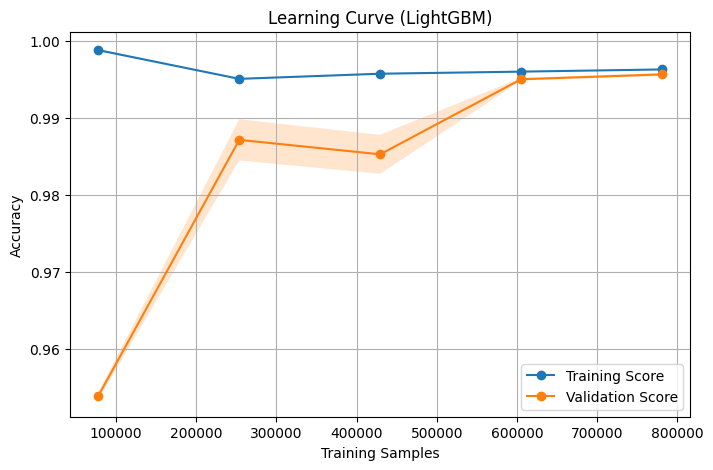

In [12]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve
from lightgbm import LGBMClassifier
from scipy.sparse import csr_matrix

# ---------------- LOAD YOUR DATA ----------------
# Example: data = pd.read_csv("your_file.csv")
# Assuming `data` is already loaded in your notebook

# ---------------- CLEAN DATA ----------------
drop_cols = ['No.', 'Time', 'Source', 'Destination', 'Info']
data = data.drop(columns=drop_cols, errors='ignore')

# ---------------- SEPARATE FEATURES & TARGET ----------------
X_raw = data.drop(columns=['__label'], errors='ignore')
y = data['__label']

# ---------------- ENCODE PROTOCOL ----------------
encoder = joblib.load(r"W:\SAMSUNG_HACKATHON\output\ohe_protocol.pkl")

if 'Protocol' in X_raw.columns:
    X_encoded = encoder.transform(X_raw[['Protocol']])   # Sparse matrix
    X_rest = X_raw.drop(columns=['Protocol'])
else:
    X_encoded = None
    X_rest = X_raw

# ---------------- COMBINE FEATURES ----------------
X_rest_np = X_rest.to_numpy()

if X_encoded is not None:
    # Convert dense numeric part to sparse matrix
    X_rest_sparse = csr_matrix(X_rest_np)
    # Stack numeric + encoded features
    X = sp.hstack([X_rest_sparse, X_encoded], format="csr")
else:
    X = csr_matrix(X_rest_np)  # keep consistent format

print("Final feature matrix shape:", X.shape)
print("Target shape:", y.shape)

# ---------------- MODEL ----------------
model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)

# ---------------- CROSS VALIDATION ----------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("\nCross-validation scores:", cv_scores)
print("Mean accuracy: %.4f (+/- %.4f)" % (cv_scores.mean(), cv_scores.std()))

# ---------------- LEARNING CURVE ----------------
train_sizes, train_scores, val_scores = learning_curve(
    model, X, y, cv=cv, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

# Mean and std
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label="Training Score")
plt.plot(train_sizes, val_mean, 'o-', label="Validation Score")

plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std,
                 val_mean + val_std, alpha=0.2)

plt.title("Learning Curve (LightGBM)")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


NameError: name 'X_train' is not defined

In [16]:
import re
import numpy as np
import pandas as pd
import joblib

# -------------------------
# Load saved model + encoder
# -------------------------
model = joblib.load("output/lightgbm_packet_model.pkl")
ohe = joblib.load("output/ohe_protocol.pkl")

# -------------------------
# Load test dataset
# -------------------------
df = pd.read_csv("TEST/robolox_test.csv")
df = df.rename(columns=lambda c: c.strip())

# -------------------------
# Feature extraction (must mirror training pipeline!)
# -------------------------
port_pattern = re.compile(r'(\d{1,5})\s*>\s*(\d{1,5})')
flags = ['SYN', 'ACK', 'PSH', 'RST', 'FIN', 'URG', 'ECE', 'CWR']
keywords = ['http', 'tls', 'quic', 'dns', 'get', 'post', 'rtp', 'rtcp', 'rtsp', 'ssl', 'video', 'audio', 'application data']

df['Info'] = df['Info'].astype(str)

# Basic derived features
df['info_len'] = df['Info'].apply(len)
df['digits_in_info'] = df['Info'].apply(lambda s: sum(ch.isdigit() for ch in s))

# Extract ports
ports = df['Info'].apply(lambda s: port_pattern.search(s))
df['src_port'] = ports.apply(lambda m: int(m.group(1)) if m else np.nan)
df['dst_port'] = ports.apply(lambda m: int(m.group(2)) if m else np.nan)

# Flags
for f in flags:
    df['flag_' + f] = df['Info'].apply(lambda s: 1 if f in s else 0)

# Keywords
for k in keywords:
    col = 'has_' + k.replace(' ', '_')
    df[col] = df['Info'].str.lower().str.contains(k).fillna(False).astype(int)

# Delta time
if 'Time' in df.columns:
    df = df.sort_values('Time').reset_index(drop=True)
    df['delta_time'] = df['Time'].diff().fillna(0.0)
else:
    df['delta_time'] = 0.0

# Candidate features
candidate_features = [
    'Length', 'info_len', 'digits_in_info', 'delta_time',
    'src_port', 'dst_port'
] + [f'flag_{f}' for f in flags] + ['has_' + k.replace(' ', '_') for k in keywords] + ['Protocol']
candidate_features = [c for c in candidate_features if c in df.columns]

# Keep only features
X_df = df[candidate_features].copy()

# Fill missing values same as training
X_df['src_port'] = X_df['src_port'].fillna(-1).astype(int)
X_df['dst_port'] = X_df['dst_port'].fillna(-1).astype(int)
if 'Length' in X_df:
    X_df['Length'] = X_df['Length'].fillna(X_df['Length'].median())

# -------------------------
# Apply encoder on Protocol
# -------------------------
cat_cols = [c for c in ['Protocol'] if c in X_df.columns]
num_cols = [c for c in X_df.columns if c not in cat_cols]

if cat_cols:
    X_cat = X_df[cat_cols].fillna('missing').astype(str)
    P = ohe.transform(X_cat)
    try:
        P_cols = list(ohe.get_feature_names_out(cat_cols))
    except AttributeError:
        P_cols = list(ohe.get_feature_names(cat_cols))
else:
    P = None
    P_cols = []

X_num = X_df[num_cols].astype(float).fillna(0.0).reset_index(drop=True)

if P is not None:
    import pandas as pd
    P_df = pd.DataFrame(P, columns=P_cols, index=X_num.index)
    X_pre = pd.concat([X_num.reset_index(drop=True), P_df.reset_index(drop=True)], axis=1)
else:
    X_pre = X_num.copy()

# Sanitize col names (LightGBM safety)
X_pre.columns = [re.sub(r'[^0-9a-zA-Z_]', '_', str(c)) for c in X_pre.columns]

# -------------------------
# Predict
# -------------------------
y_pred = model.predict(X_pre)

# -------------------------
# Save or inspect results
# -------------------------
df_out = df.copy()
df_out['predicted_label'] = y_pred
df_out.to_csv("robolox_test_predictions.csv", index=False)

print("Predictions saved to robolox_test_predictions.csv")
print("Sample predictions:", df_out[['predicted_label']].head(10))


Predictions saved to robolox_test_predictions.csv
Sample predictions:   predicted_label
0    web_browsing
1          gaming
2          gaming
3          gaming
4          gaming
5          gaming
6          gaming
7          gaming
8          gaming
9          gaming


In [6]:
import re
import numpy as np
import pandas as pd
import joblib

# -------------------------
# Load saved model + encoder
# -------------------------
model = joblib.load("output/lightgbm_packet_model.pkl")
ohe = joblib.load("output/ohe_protocol.pkl")

# -------------------------
# Load test dataset
# -------------------------
# Use "packets.csv" for this run
df = pd.read_csv("TEST/packets2.csv") 
df = df.rename(columns=lambda c: c.strip())

# -------------------------
# Feature extraction (conditional)
# -------------------------
if 'Info' in df.columns:
    print("Performing feature extraction from 'Info' column...")
    port_pattern = re.compile(r'(\d{1,5})\s*>\s*(\d{1,5})')
    flags = ['SYN', 'ACK', 'PSH', 'RST', 'FIN', 'URG', 'ECE', 'CWR']
    keywords = ['http', 'tls', 'quic', 'dns', 'get', 'post', 'rtp', 'rtcp', 'rtsp', 'ssl', 'video', 'audio', 'application data']

    df['Info'] = df['Info'].astype(str)

    # Basic derived features
    df['info_len'] = df['Info'].apply(len)
    df['digits_in_info'] = df['Info'].apply(lambda s: sum(ch.isdigit() for ch in s))

    # Extract ports
    ports = df['Info'].apply(lambda s: port_pattern.search(s))
    df['src_port'] = ports.apply(lambda m: int(m.group(1)) if m else np.nan)
    df['dst_port'] = ports.apply(lambda m: int(m.group(2)) if m else np.nan)

    # Flags
    for f in flags:
        df['flag_' + f] = df['Info'].apply(lambda s: 1 if f in s else 0)

    # Keywords
    for k in keywords:
        col = 'has_' + k.replace(' ', '_')
        df[col] = df['Info'].str.lower().str.contains(k).fillna(False).astype(int)

    # Delta time
    if 'Time' in df.columns:
        df = df.sort_values('Time').reset_index(drop=True)
        df['delta_time'] = df['Time'].diff().fillna(0.0)
    else:
        df['delta_time'] = 0.0
else:
    print("'Info' column not found. Skipping feature extraction.")


# Candidate features (use the model's expected features)
candidate_features = model.feature_name_
candidate_features = [c for c in candidate_features if c in df.columns]


# Keep only features
X_df = df[candidate_features].copy()

# Fill missing values same as training
if 'src_port' in X_df.columns:
    X_df['src_port'] = X_df['src_port'].fillna(-1).astype(int)
if 'dst_port' in X_df.columns:
    X_df['dst_port'] = X_df['dst_port'].fillna(-1).astype(int)
if 'Length' in X_df.columns:
    X_df['Length'] = X_df['Length'].fillna(X_df['Length'].median())

# -------------------------
# Apply encoder on Protocol
# -------------------------
cat_cols = [c for c in ['Protocol'] if c in X_df.columns]
num_cols = [c for c in X_df.columns if c not in cat_cols]

if cat_cols:
    X_cat = X_df[cat_cols].fillna('missing').astype(str)
    P = ohe.transform(X_cat)
    try:
        P_cols = list(ohe.get_feature_names_out(cat_cols))
    except AttributeError:
        P_cols = list(ohe.get_feature_names(cat_cols))
else:
    P = None
    P_cols = []

X_num = X_df[num_cols].astype(float).fillna(0.0).reset_index(drop=True)

if P is not None and P.shape[1] > 0:
    import pandas as pd
    P_df = pd.DataFrame(P, columns=P_cols, index=X_num.index)
    X_pre = pd.concat([X_num.reset_index(drop=True), P_df.reset_index(drop=True)], axis=1)
else:
    X_pre = X_num.copy()

# Sanitize col names (LightGBM safety)
X_pre.columns = [re.sub(r'[^0-9a-zA-Z_]', '_', str(c)) for c in X_pre.columns]

# Align columns with the model's training columns
X_pre = X_pre.reindex(columns=model.feature_name_, fill_value=0)


# -------------------------
# Predict
# -------------------------
y_pred = model.predict(X_pre)

# -------------------------
# Save or inspect results
# -------------------------
df_out = df.copy()
df_out['predicted_label'] = y_pred
df_out.to_csv("packets_predictions.csv", index=False)

print("Predictions saved to packets2_predict.csv")
print("Sample predictions:\n", df_out[['predicted_label']].head(10))

'Info' column not found. Skipping feature extraction.
Predictions saved to packets2_predict.csv
Sample predictions:
   predicted_label
0    web_browsing
1  audiostreaming
2  audiostreaming
3  audiostreaming
4  audiostreaming
5  audiostreaming
6          gaming
7  audiostreaming
8  audiostreaming
9  audiostreaming


In [1]:
import requests

# Your API URL
url = "https://karan0301-network-traffic-api.hf.space/predict_csv"

# Open the CSV file you want to send
with open("TEST/packets.csv", "rb") as file:
    files = {"file": file}
    response = requests.post(url, files=files)

# Check response
if response.status_code == 200:
    # Save predictions locally
    with open("predictedhug_output.csv", "wb") as f:
        f.write(response.content)
    print("✅ Predictions saved to predictedhu33_output.csv")
else:
    print("❌ Error:", response.status_code, response.text)


✅ Predictions saved to predictedhu33_output.csv


In [2]:
import socket
import struct
import textwrap

# Helper function to format bytes nicely
def format_bytes(data):
    return ' '.join(f'{b:02x}' for b in data)

# Create a raw socket and bind it to the public interface
try:
    # AF_INET for IP, SOCK_RAW for raw packets
    conn = socket.socket(socket.AF_INET, socket.SOCK_RAW, socket.IPPROTO_IP)
    host = socket.gethostbyname(socket.gethostname())
    conn.bind((host, 0))

    # Include IP headers
    conn.setsockopt(socket.IPPROTO_IP, socket.IP_HDRINCL, 1)
    
    # Enable promiscuous mode (Windows only)
    conn.ioctl(socket.SIO_RCVALL, socket.RCVALL_ON)
except Exception as e:
    print("Error creating socket:", e)
    exit()

print(f"Listening on {host}... Press Ctrl+C to stop.")

try:
    while True:
        raw_data, addr = conn.recvfrom(65535)
        # Extract IP header (first 20 bytes)
        ip_header = raw_data[:20]
        iph = struct.unpack('!BBHHHBBH4s4s', ip_header)
        
        version_ihl = iph[0]
        version = version_ihl >> 4
        ihl = (version_ihl & 0xF) * 4
        ttl = iph[5]
        protocol = iph[6]
        src_ip = socket.inet_ntoa(iph[8])
        dest_ip = socket.inet_ntoa(iph[9])
        
        print(f"IP Version: {version}, Header Length: {ihl}, TTL: {ttl}")
        print(f"Protocol: {protocol}, Source: {src_ip}, Destination: {dest_ip}")
        print(f"Raw Data: {format_bytes(raw_data[:40])}")  # show first 40 bytes
        print("-"*50)
except KeyboardInterrupt:
    print("Stopping packet capture...")
finally:
    # Disable promiscuous mode (Windows only)
    try:
        conn.ioctl(socket.SIO_RCVALL, socket.RCVALL_OFF)
    except:
        pass
    conn.close()


Error creating socket: [WinError 10013] An attempt was made to access a socket in a way forbidden by its access permissions


NameError: name 'host' is not defined